Repo link:


# Part 0. Downloading the dataset

In [ ]:
!sh ./download-data.sh

mkdir: cannot create directory ‘data’: File exists
--2021-11-30 16:21:36--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘data/train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  67.1MB/s    in 2.6s    

2021-11-30 16:21:38 (67.1 MB/s) - ‘data/train_32x32.mat’ saved [182040794/182040794]

--2021-11-30 16:21:38--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘data/test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  71.4MB/s    in 0.9s    

2021-11-30 16:21:39 (71.4 MB/s) - ‘data/test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-1

# Part 1. Implementing [KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) with numpy.

## K-neariest neighbor classifier

You are implementing one of the simplest machine learning algorithms, a K-Nearest Neighbor Classifier.
We will apply it to tasks:
- binary classification (that is, only two classes)
- multi-class classification (that is, multiple classes)

Since the method needs a hyperparameter - the number of neighbors, we will select it based on cross-validation.

Before completing the assignment:
- Put the files 'knn.py', 'metrics.py', 'dataset.py', `download_data.sh` into the current directory (/ content /)
- run the file `download_data.sh` to download the data that we will use for training into the data directory (data will appear during the launch of the bash script)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [8]:
from dataset import load_svhn

In [10]:
from knn import KNN

In [12]:
from metrics import binary_classification_metrics, multiclass_accuracy

## Load and visualize data

The task has already given the `load_svhn` function, which loads data from disk. It returns data for training and testing as numpy arrays.

We'll use numbers from the Street View House Numbers dataset (SVHN, http://ufldl.stanford.edu/housenumbers/).

In [13]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

In [15]:
X = np.concatenate([train_X,test_X],axis=0)
y = np.concatenate([train_y,test_y],axis=0)
print(X.shape, y.shape)

(1100, 32, 32, 3) (1100,)


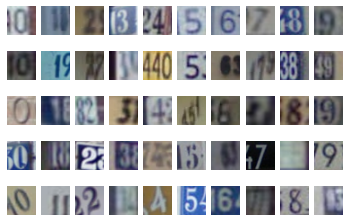

In [17]:
samples_per_class, plot_index = 5, 1

for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

## First we implement KNN for binary classification

As a binary classification task, we will train a model to distinguish the number 0 from the number 9.

In [19]:
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0
binary_mask = (y == 9) | (y == 0)
binary_X = X[binary_mask]

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0
binary_y = y[binary_mask] == 0

binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)
binary_X = binary_X.reshape(binary_X.shape[0],-1)

In [21]:
print(binary_y)

[ True  True  True  True  True False  True False  True False  True False
  True False  True False  True  True  True False  True False  True  True
  True  True False False False  True  True  True False False  True  True
 False  True False  True  True False  True  True  True  True  True  True
 False  True  True False False  True False  True False False False  True
  True False False False False False False False False  True False False
 False False  True False False  True  True  True  True  True  True False
  True False  True False False False  True False  True False  True False
 False  True  True False  True False  True False  True  True False  True
 False  True False False False  True False  True  True  True  True  True
  True  True  True  True False False  True  True  True  True False  True
 False  True  True  True  True]


In [22]:
knn_classifier = KNN(k=1, metric='manhattan')
knn_classifier.fit(binary_train_X, binary_train_y)

### It's time to write some code!

Implement the functions `compute_distances_two_loops`,` compute_distances_one_loop` and `compute_distances_no_loops`
in the file `knn.py`.

These functions build an array of distances between all vectors in the test set and in the training set.
As a result, they must build an array of size `(num_test, num_train)`, where the coordinate `[i][j]` corresponds to the distance between the i-th vector in test (`test[i]`) and the j-th vector in train ( `train[j]`).

**Please note** We will use the measures L1 and L2 as a distance.

In [23]:
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [25]:
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [28]:
a = binary_test_X[:,np.newaxis,:]
b = knn_classifier.train_X[np.newaxis,:,:]
diff = np.abs(a-b)
np.sum(diff,axis=2).shape

(16, 121)

In [29]:
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [30]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

10 loops, best of 5: 19.8 ms per loop
100 loops, best of 5: 11.2 ms per loop
10 loops, best of 5: 21.6 ms per loop


In [31]:
prediction = knn_classifier.predict(binary_test_X)

In [32]:
print(prediction)

[ True  True False  True  True  True False  True  True False  True  True
  True  True False False]


In [33]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


In [34]:
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 0.75, Precision: 0.75, Recall: 1.00, F1: 0.86


## Cross-validation

Let's try to find the best value for the parameter k for the KNN algorithm!

For this we will use k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). We'll split the training data into 5 folds and in turn use each of them as validation data and the rest as training data.

As a final estimate of the effectiveness of k, we will average the F1 score across all folds.
After that, we'll just pick the k value with the best metric value.

In [36]:
from sklearn.model_selection import KFold

num_folds = 5
kf = KFold(n_splits=num_folds)
train_folds_X, train_folds_y = [], []

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  

for k in k_choices:
    f1_s = []
    for train_idx, test_idx in kf.split(binary_X):
        knn_classifier_k = KNN(k=k, metric='manhattan')
        knn_classifier_k.fit(binary_X[train_idx], binary_y[train_idx])
        prediction = knn_classifier_k.predict(binary_X[test_idx])
        _, _ , f1, _ = binary_classification_metrics(prediction, binary_y[test_idx])
        f1_s.append(f1)
        
    k_to_f1[k] = np.mean(f1_s)

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 1, f1 = 0.672937
k = 2, f1 = 0.672937
k = 3, f1 = 0.672937
k = 5, f1 = 0.672937
k = 8, f1 = 0.672937
k = 10, f1 = 0.672937
k = 15, f1 = 0.672937
k = 20, f1 = 0.672937
k = 25, f1 = 0.672937
k = 50, f1 = 0.672937


In [37]:
from sklearn.model_selection import KFold
num_folds = 5
kf = KFold(n_splits=num_folds)

In [38]:
print(list(kf.split(knn_classifier.train_X))[0])

(array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]))


### Check how well the best k value works on test data

In [39]:
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 1
Accuracy: 0.75, Precision: 0.75, Recall: 1.00, F1: 0.86


## multi-class classification

We pass to the next stage - classification for each digit.

In [40]:
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)
X = X.reshape(X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [41]:
predict = knn_classifier.predict(test_X)

In [42]:
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.07


Cross-validation again. Now our main metric is accuracy, and we will also average it over all folds.

In [43]:
num_folds = 5
train_folds_X, train_folds_y = [], []

from sklearn.model_selection import KFold
num_folds = 5
kf = KFold(n_splits=num_folds)
k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    acc_s = []
    for train_idx, test_idx in kf.split(X):
        knn_classifier_k = KNN(k=k, metric='manhattan')
        knn_classifier_k.fit(X[train_idx], y[train_idx])
        prediction = knn_classifier_k.predict(X[test_idx])
        acc = multiclass_accuracy(prediction, y[test_idx])
        acc_s.append(acc)
        
    
    k_to_accuracy[k] = np.mean(acc_s)

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

k = 1, accuracy = 0.250909
k = 2, accuracy = 0.250909
k = 3, accuracy = 0.250909
k = 5, accuracy = 0.250909
k = 8, accuracy = 0.250909
k = 10, accuracy = 0.250909
k = 15, accuracy = 0.250909
k = 20, accuracy = 0.250909
k = 25, accuracy = 0.250909
k = 50, accuracy = 0.250909


In [45]:
print(X.shape)

(1100, 3072)


### Final test - classification into 10 classes on the test sample (test data)

If implemented correctly, you should see an accuracy of at least **0.2**.

In [46]:
best_k = 1

best_knn_classifier = KNN(k=best_k, metric='manhattan')
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


### Now it remains to push all 5 files into the repository, and attach the link to your repository to the classroom ... Or, before that, you can try to quickly implement this with sklearn!

# Part 2 (Bonus). Sklearn 

Compare your models for both metrics with similar ones in sklearn.